# วิเคราะห์หาข้อมูลที่สำคัญใน Payment

In [156]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colormaps  # Import colormaps

pd.options.display.float_format = '{:,.2f}'.format
# ปิดการแสดงคำเตือน SettingWithCopyWarning ชั่วคราว
pd.options.mode.chained_assignment = None  # ปิดการแสดงคำเตือน

## กำหนด font ภาษาไทยสำหรับการแสดงผลในกราฟ

In [73]:
from matplotlib.font_manager import fontManager
# import matplotlib as mpl

# Add font to font manager
fontManager.addfont('/Users/seal/Documents/GitHub/hackathon-nt-2024/fonts/Sarabun/Sarabun-Regular.ttf')
# Set the font for your plot
plt.rcParams['font.family'] = 'Sarabun'
# Set font size for all plot elements
plt.rcParams['font.size'] = 12
# mpl.rc("font", family="Sarabun", size=24)

## อ่านไฟล์ข้อมูล Payment ที่สรุปมาแล้ว

In [74]:
df = pd.read_csv("SUMMARY_PAYMENT.csv")

## ดูว่ามี columns อะไรบ้าง

In [75]:
df.columns

Index(['ACCOUNT_NO', 'SERVICED_NUMBER', 'PAYMENT_DATE', 'INVOICE_DATE',
       'PAY_TYPE', 'payment_type', 'AMOUNT', 'DAYS_DIFF'],
      dtype='object')

### ลบบรรทัดที่ไม่ต้องการออก กรณี ไม่มีระยะเวลาชำระ

In [76]:
df = df.dropna(subset=['DAYS_DIFF'])

### แปลงข้อมูลเป็นแบบวันที่

In [120]:
# แปลงคอลัมน์ PAYMENT_DATE ให้มีเฉพาะวันที่ โดยตัดเวลาส่วนออกไป
# ตั้งค่าประเภทของคอลัมน์ PAYMENT_DATE เป็น datetime
df['PAYMENT_DATE'] = pd.to_datetime(df['PAYMENT_DATE'], format='%Y-%m-%d')
# ตั้งค่าประเภทของคอลัมน์ INVOICE_DATE เป็น datetime
df['INVOICE_DATE'] = pd.to_datetime(df['INVOICE_DATE'], format='%Y-%m-%d')

df['PAYMENT_DATE'] = df['PAYMENT_DATE'].dt.date
df['INVOICE_DATE'] = df['INVOICE_DATE'].dt.date

### ลอง plot ดูการกระจายตัวของ ระยะเวลาชำระ

In [121]:
# Create a boxplot to visualize the distribution of 'DAYS_DIFF'
filtered_df = df[(df['DAYS_DIFF'] < 90) & (df['DAYS_DIFF'] > 0)]
print("Date diff max", filtered_df['DAYS_DIFF'].max())
print("Date diff min", filtered_df['DAYS_DIFF'].min())
print("Date diff count", filtered_df['DAYS_DIFF'].value_counts())

Date diff max 89
Date diff min 1
Date diff count DAYS_DIFF
32    2328974
31    1431820
33    1054354
34     825009
26     669234
       ...   
5          64
4          21
3          10
2           6
1           1
Name: count, Length: 89, dtype: int64


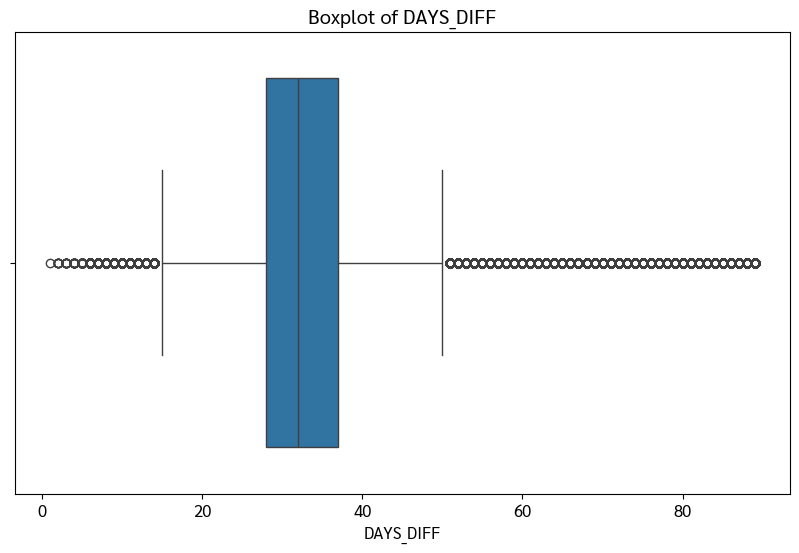

In [122]:

plt.figure(figsize=(10, 6))
sns.boxplot(x=filtered_df['DAYS_DIFF'])
plt.title('Boxplot of DAYS_DIFF')
plt.xlabel('DAYS_DIFF')
plt.show()

### ลอง plot ดูการกระจายตัวของ ระยะเวลาชำระ ลองปรับช่วงระยะเวลา

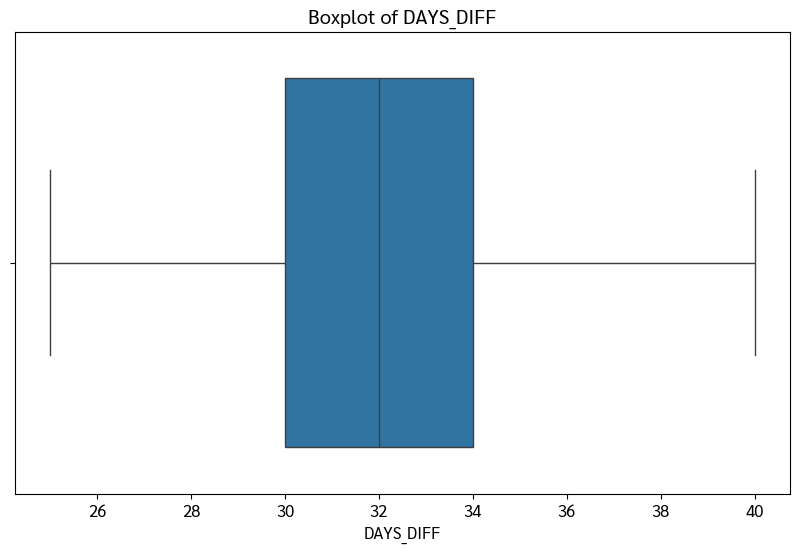

In [123]:
# Create a boxplot to visualize the distribution of 'DAYS_DIFF'
filtered_df = df[(df['DAYS_DIFF'] <= 40) & (df['DAYS_DIFF'] >= 25)]
plt.figure(figsize=(10, 6))
sns.boxplot(x=filtered_df['DAYS_DIFF'])
plt.title('Boxplot of DAYS_DIFF')
plt.xlabel('DAYS_DIFF')
plt.show()

### ดูการกระจายตัวของข้อมูล

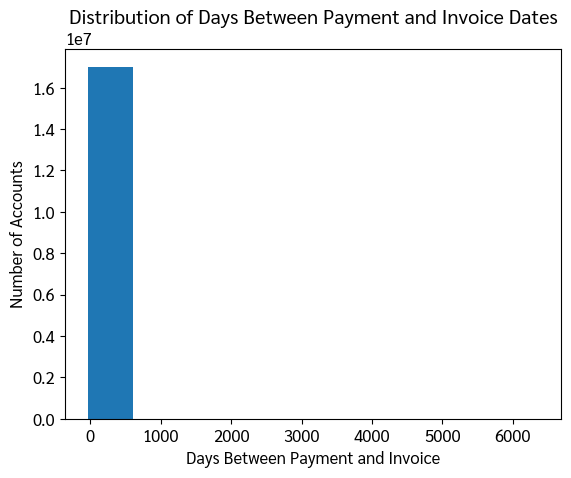

In [124]:
# Create a histogram to visualize the distribution of 'DAYS_DIFF'
plt.hist(df['DAYS_DIFF'])
plt.xlabel('Days Between Payment and Invoice')
plt.ylabel('Number of Accounts')
plt.title('Distribution of Days Between Payment and Invoice Dates')
plt.show()


### กำหนดแค่ 90 วันหรือ 3 เดือน เนื่องจากปกติ การชำระเกินเวลา 90 วันลูกค้าจะถูกระงับการใช้งาน

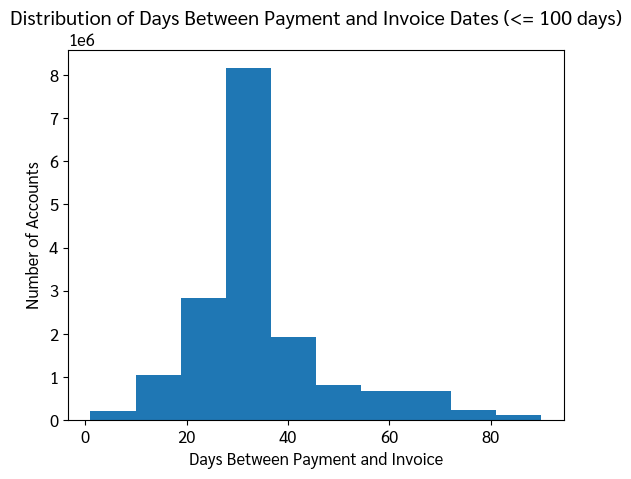

In [125]:
# Filter data for DAYS_DIFF less than 90
filtered_df = df[(df['DAYS_DIFF'] <= 90) & (df['DAYS_DIFF'] >= 0)]

# Create a histogram to visualize the distribution
plt.hist(filtered_df['DAYS_DIFF'])
plt.xlabel('Days Between Payment and Invoice')
plt.ylabel('Number of Accounts')
plt.title('Distribution of Days Between Payment and Invoice Dates (<= 100 days)')
plt.show()

### กรณีนำ DAYS_DIFF ไปใช้กับ Model ทำการปรับให้เป็น Normal Distribution ที่มี Skewness ใกล้เคียง 0

In [126]:
'''

# คำนวณค่า Skewness ก่อนการแปลงข้อมูล
original_skewness = stats.skew(filtered_df['DAYS_DIFF'])
print(f"Original Skewness: {original_skewness}")

# แปลงข้อมูลโดยใช้ Log Transformation
log_transformed_data = np.log1p(filtered_df['DAYS_DIFF'])  # ใช้ log(1 + data) เพื่อหลีกเลี่ยง log(0)

# แปลงข้อมูลโดยใช้ Square Root Transformation
sqrt_transformed_data = np.sqrt(filtered_df['DAYS_DIFF'])

# แปลงข้อมูลโดยใช้ Box-Cox Transformation
boxcox_transformed_data, fitted_lambda = stats.boxcox(filtered_df['DAYS_DIFF'])

# คำนวณค่า Skewness หลังการแปลงข้อมูล
log_skewness = stats.skew(log_transformed_data)
sqrt_skewness = stats.skew(sqrt_transformed_data)
boxcox_skewness = stats.skew(boxcox_transformed_data)

print(f"Log Transformed Skewness: {log_skewness}")
print(f"Square Root Transformed Skewness: {sqrt_skewness}")
print(f"Box-Cox Transformed Skewness: {boxcox_skewness}")

# วาดกราฟเปรียบเทียบการกระจายตัวก่อนและหลังการแปลงข้อมูล
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

sns.histplot(filtered_df['DAYS_DIFF'], kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Original Data')

sns.histplot(log_transformed_data, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('Log Transformed Data')

sns.histplot(sqrt_transformed_data, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Square Root Transformed Data')

sns.histplot(boxcox_transformed_data, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Box-Cox Transformed Data')

plt.tight_layout()
plt.show()

'''

'\n\n# คำนวณค่า Skewness ก่อนการแปลงข้อมูล\noriginal_skewness = stats.skew(filtered_df[\'DAYS_DIFF\'])\nprint(f"Original Skewness: {original_skewness}")\n\n# แปลงข้อมูลโดยใช้ Log Transformation\nlog_transformed_data = np.log1p(filtered_df[\'DAYS_DIFF\'])  # ใช้ log(1 + data) เพื่อหลีกเลี่ยง log(0)\n\n# แปลงข้อมูลโดยใช้ Square Root Transformation\nsqrt_transformed_data = np.sqrt(filtered_df[\'DAYS_DIFF\'])\n\n# แปลงข้อมูลโดยใช้ Box-Cox Transformation\nboxcox_transformed_data, fitted_lambda = stats.boxcox(filtered_df[\'DAYS_DIFF\'])\n\n# คำนวณค่า Skewness หลังการแปลงข้อมูล\nlog_skewness = stats.skew(log_transformed_data)\nsqrt_skewness = stats.skew(sqrt_transformed_data)\nboxcox_skewness = stats.skew(boxcox_transformed_data)\n\nprint(f"Log Transformed Skewness: {log_skewness}")\nprint(f"Square Root Transformed Skewness: {sqrt_skewness}")\nprint(f"Box-Cox Transformed Skewness: {boxcox_skewness}")\n\n# วาดกราฟเปรียบเทียบการกระจายตัวก่อนและหลังการแปลงข้อมูล\nfig, axes = plt.subplots(2, 2, f

In [127]:
# boxcox_transformed_data

### หามูลค่ารวม ที่ชำระ ในแต่ละ ระยะเวลาที่ชำระ

In [128]:
# คำนวณยอดรวมของ AMOUNT สำหรับแต่ละ DAYS_DIFF
amount_sum_per_days_diff = filtered_df.groupby('DAYS_DIFF')['AMOUNT'].sum().reset_index()

# แสดงผลลัพธ์
print(amount_sum_per_days_diff)

    DAYS_DIFF        AMOUNT
0           1        100.00
1           2      2,250.00
2           3      5,899.50
3           4      8,861.72
4           5     30,952.86
..        ...           ...
85         86  8,094,689.01
86         87  6,450,227.26
87         88  8,571,640.20
88         89  5,095,598.90
89         90 11,177,742.64

[90 rows x 2 columns]


### Plot ดูการกระจายตัวของยอดรับชำระ

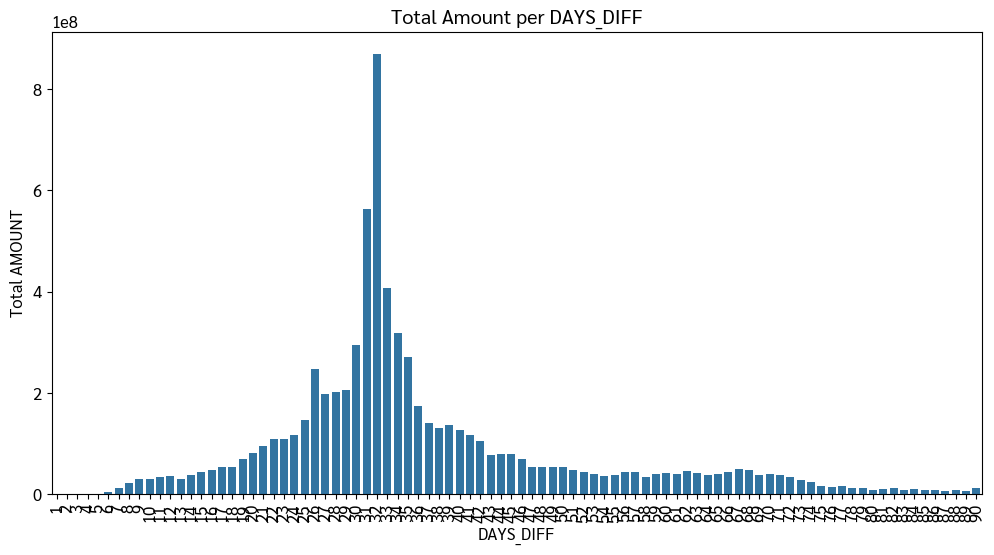

In [129]:
# วาดกราฟ bar plot
plt.figure(figsize=(12, 6))
sns.barplot(x='DAYS_DIFF', y='AMOUNT', data=amount_sum_per_days_diff)
plt.title('Total Amount per DAYS_DIFF')
plt.xlabel('DAYS_DIFF')
plt.ylabel('Total AMOUNT')
plt.xticks(rotation=90)  # หมุน label ของแกน x หากมีค่ามาก
plt.show()

In [130]:
amount_sum_per_days_diff

,DAYS_DIFF,AMOUNT
0,1,100.00
1,2,"2,250.00"
2,3,"5,899.50"
3,4,"8,861.72"
4,5,"30,952.86"
...,...,...
85,86,"8,094,689.01"
86,87,"6,450,227.26"
87,88,"8,571,640.20"
88,89,"5,095,598.90"


# ทำการหา percentiles เพื่อเลือกช่วงระยะเวลาการชำระเงิน
## เพื่อนำมากำหนดกลุ่มเป้าหมาย

In [131]:
# Calculate percentiles (adjust percentiles as needed)
percentiles = [.25, .5, .75]
date_diff_percentiles = df['DAYS_DIFF'].quantile(percentiles)
date_diff_percentiles

0.25   28.00
0.50   32.00
0.75   38.00
Name: DAYS_DIFF, dtype: float64

In [132]:
# กำหนดค่าร้อยละให้กับตัวแปร
percentile_25 = date_diff_percentiles[0.25]
percentile_50 = date_diff_percentiles[0.5]
percentile_75 = date_diff_percentiles[0.75]

# แสดงผลลัพธ์
print(f"25th percentile: {percentile_25}")
print(f"50th percentile: {percentile_50}")
print(f"75th percentile: {percentile_75}")

25th percentile: 28.0
50th percentile: 32.0
75th percentile: 38.0


### เลือกกลุ่มเป้าหมายตามค่าของ percentile 25th, 50th, 75th

In [133]:
target = (df['DAYS_DIFF'] >= 28) & (df['DAYS_DIFF'] <= 38)

In [134]:
df[target]

,ACCOUNT_NO,SERVICED_NUMBER,PAYMENT_DATE,INVOICE_DATE,PAY_TYPE,payment_type,AMOUNT,DAYS_DIFF
0,100000098,021781046,2022-01-12,2021-12-11,DC,Batch,100.00,32
1,100000098,021781046,2022-02-14,2022-01-10,DC,Batch,100.00,35
2,100000098,021781046,2022-03-14,2022-02-10,DC,Batch,100.00,32
3,100000098,021781046,2022-04-12,2022-03-11,DC,Batch,100.00,32
4,100000098,021781046,2022-05-12,2022-04-11,DC,Batch,100.00,31
...,...,...,...,...,...,...,...,...
17021821,104533237998,7736J0940,2022-12-27,2022-11-26,CA,POS,76.77,31
17021822,104533238012,7621J3696,2022-12-27,2022-11-26,CA,POS,345.48,31
17021823,104533238013,7621J3702,2022-12-27,2022-11-26,CA,POS,345.48,31
17021860,104533240112,2321J5023,2022-12-29,2022-11-26,DD,eService,427.74,33


In [135]:
df[target].columns

Index(['ACCOUNT_NO', 'SERVICED_NUMBER', 'PAYMENT_DATE', 'INVOICE_DATE',
       'PAY_TYPE', 'payment_type', 'AMOUNT', 'DAYS_DIFF'],
      dtype='object')

In [136]:
df.dtypes

ACCOUNT_NO           int64
SERVICED_NUMBER     object
PAYMENT_DATE        object
INVOICE_DATE        object
PAY_TYPE            object
payment_type        object
AMOUNT             float64
DAYS_DIFF            int64
dtype: object

### กลุ่มเป้าหมาย และ columns ที่จะใช้งาน

In [137]:
target_group = df[target]
target_group = target_group[['ACCOUNT_NO', 'SERVICED_NUMBER', 'PAYMENT_DATE',
       'INVOICE_DATE', 'PAY_TYPE', 'payment_type', 'AMOUNT', 'DAYS_DIFF',]].reset_index(drop=True)
target_group

,ACCOUNT_NO,SERVICED_NUMBER,PAYMENT_DATE,INVOICE_DATE,PAY_TYPE,payment_type,AMOUNT,DAYS_DIFF
0,100000098,021781046,2022-01-12,2021-12-11,DC,Batch,100.00,32
1,100000098,021781046,2022-02-14,2022-01-10,DC,Batch,100.00,35
2,100000098,021781046,2022-03-14,2022-02-10,DC,Batch,100.00,32
3,100000098,021781046,2022-04-12,2022-03-11,DC,Batch,100.00,32
4,100000098,021781046,2022-05-12,2022-04-11,DC,Batch,100.00,31
...,...,...,...,...,...,...,...,...
8724390,104533237998,7736J0940,2022-12-27,2022-11-26,CA,POS,76.77,31
8724391,104533238012,7621J3696,2022-12-27,2022-11-26,CA,POS,345.48,31
8724392,104533238013,7621J3702,2022-12-27,2022-11-26,CA,POS,345.48,31
8724393,104533240112,2321J5023,2022-12-29,2022-11-26,DD,eService,427.74,33


In [143]:
target_group.dtypes

ACCOUNT_NO           int64
SERVICED_NUMBER     object
PAYMENT_DATE        object
INVOICE_DATE        object
PAY_TYPE            object
payment_type        object
AMOUNT             float64
DAYS_DIFF            int64
dtype: object

In [139]:
target_group['AMOUNT'].sum()

3579169081.35

## ดูลักษณะการออก Invoice

In [144]:
# Group by day in 'INVOICE_DATE'
target_group['INVOICE_DATE'] = pd.to_datetime(target_group['INVOICE_DATE'], format='%Y-%m-%d')

# Group by day in 'INVOICE_DATE'
daily_grouped_df = target_group.groupby(target_group['INVOICE_DATE'].dt.day)

# Calculate daily sum of AMOUNT
daily_amount_sum = daily_grouped_df['AMOUNT'].sum()

# Print some information about the grouped DataFrame
print(daily_grouped_df.size())  # Print the number of groups (days)
# print(list(daily_grouped_df))  # Print a list of group names (days)
# Print the result (Series showing daily sum of amount)
print(daily_amount_sum)


INVOICE_DATE
1       69078
5       78292
6      864482
10     224573
11    1837081
15     225234
16    1920970
20     128262
21    1695457
25      82568
26     998666
28     103431
30     154318
31     341983
dtype: int64
INVOICE_DATE
1     14,936,703.19
5     34,172,245.28
6    412,674,602.58
10    82,898,103.37
11   815,738,495.31
15    71,863,419.09
16   784,981,954.36
20    39,444,426.70
21   619,654,633.53
25    19,428,498.60
26   335,253,720.86
28    44,227,294.57
30    95,524,936.63
31   208,370,047.28
Name: AMOUNT, dtype: float64


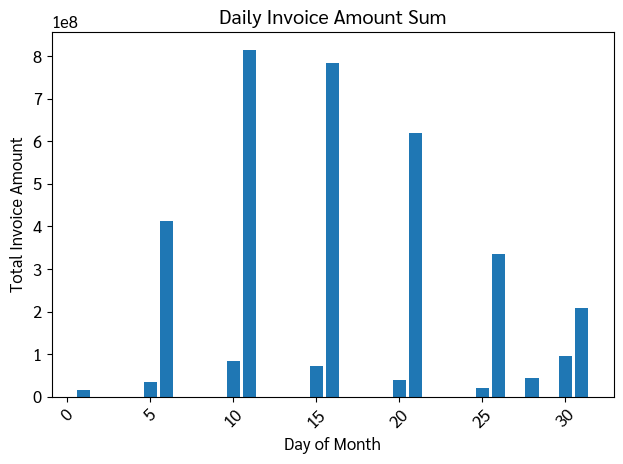

In [ ]:
# Create a bar graph to visualize daily sum of amount
plt.bar(daily_amount_sum.index, daily_amount_sum.values)
plt.xlabel('Day of Month')
plt.ylabel('Total Invoice Amount')
plt.title('Daily Invoice Amount Sum')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability (optional)
plt.tight_layout()
plt.show()

### การออกบิลเรียกเก็บ ออกเป็นรอบเวลา เช่น ทุกวันที่ 5, 10, 15, 20, 25

INVOICE_DATE
2022-11-01      729,667.98
2022-11-06   33,116,245.78
2022-11-11   65,387,519.02
2022-11-16   59,869,170.61
2022-11-21   46,196,917.94
2022-11-26   18,415,413.60
2022-11-30   12,551,010.87
Name: AMOUNT, dtype: float64
236265945.79999998


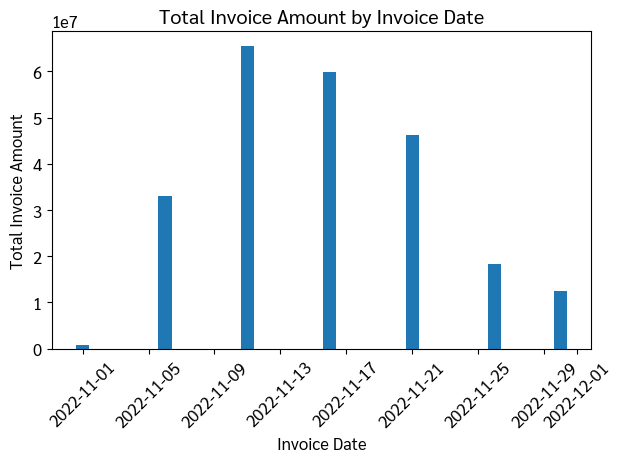

In [145]:
# Assuming you have a DataFrame 'df' with the mentioned columns
year = 2022
month = 11

target_group['INVOICE_DATE'] = pd.to_datetime(target_group['INVOICE_DATE'], format='%Y-%m-%d')

# Filter for invoices in November 2022
filtered_df = target_group[(target_group['INVOICE_DATE'].dt.year == year) & (target_group['INVOICE_DATE'].dt.month == month)]

# Assuming you have a DataFrame 'df' with the mentioned columns
amount_sum_by_invoice_date = filtered_df.groupby(['INVOICE_DATE'])['AMOUNT'].sum()

# Print the result (Series)
print(amount_sum_by_invoice_date)
print(amount_sum_by_invoice_date.sum())

# Create a bar graph to visualize total invoice amount by invoice date
plt.bar(amount_sum_by_invoice_date.index, amount_sum_by_invoice_date.values)
plt.xlabel('Invoice Date')
plt.ylabel('Total Invoice Amount')
plt.title('Total Invoice Amount by Invoice Date')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

## ดูลักษณะการจ่ายเงินของลูกค้า

### ระยะเวลากระจายตัวสอดคล้องไปกับรอบการออกบิลเรียกเก็บ

PAYMENT_DATE
1     101321
2      54335
3      59732
4      84015
5      84301
6      83420
7     462724
8     161928
9     152198
10    134434
11    159710
12    696036
13    310558
14    457516
15    271683
16    127215
17    958033
18    509231
19    345375
20    197383
21    216150
22    830546
23    294717
24    208866
25    268027
26    130476
27    529082
28    410067
29    236283
30    118656
31     70377
dtype: int64
PAYMENT_DATE
1     39,379,427.38
2     29,712,919.65
3     31,889,964.10
4     44,302,649.96
5     45,471,233.27
6     45,011,694.69
7    222,687,170.84
8     80,406,678.00
9     76,783,671.33
10    69,097,891.97
11    86,824,522.55
12   296,485,426.62
13   122,983,616.06
14   186,513,559.72
15   125,066,488.25
16    63,519,461.92
17   355,444,397.77
18   195,115,729.72
19   136,920,513.47
20    83,003,426.39
21    99,120,129.63
22   287,533,434.19
23   110,646,643.22
24    77,893,443.64
25   102,932,281.11
26    54,829,759.68
27   153,405,629.26
28   160,545,900.5

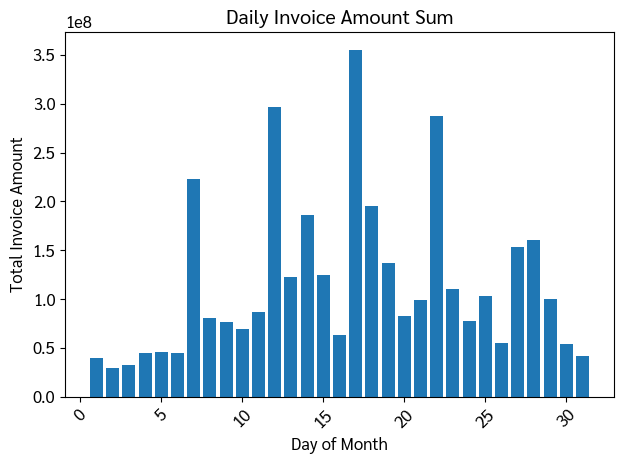

In [146]:
# Group by day in 'INVOICE_DATE'
target_group['PAYMENT_DATE'] = pd.to_datetime(target_group['PAYMENT_DATE'], format='%Y-%m-%d')
# Group by day in 'INVOICE_DATE'
daily_grouped_df = target_group.groupby(target_group['PAYMENT_DATE'].dt.day)

# Calculate daily sum of AMOUNT
daily_amount_sum = daily_grouped_df['AMOUNT'].sum()

# Print some information about the grouped DataFrame
print(daily_grouped_df.size())  # Print the number of groups (days)
# print(list(daily_grouped_df))  # Print a list of group names (days)
# Print the result (Series showing daily sum of amount)
print(daily_amount_sum)

# Create a bar graph to visualize daily sum of amount
plt.bar(daily_amount_sum.index, daily_amount_sum.values)
plt.xlabel('Day of Month')
plt.ylabel('Total Invoice Amount')
plt.title('Daily Invoice Amount Sum')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability (optional)
plt.tight_layout()
plt.show()


In [147]:
target_group

,ACCOUNT_NO,SERVICED_NUMBER,PAYMENT_DATE,INVOICE_DATE,PAY_TYPE,payment_type,AMOUNT,DAYS_DIFF
0,100000098,021781046,2022-01-12,2021-12-11,DC,Batch,100.00,32
1,100000098,021781046,2022-02-14,2022-01-10,DC,Batch,100.00,35
2,100000098,021781046,2022-03-14,2022-02-10,DC,Batch,100.00,32
3,100000098,021781046,2022-04-12,2022-03-11,DC,Batch,100.00,32
4,100000098,021781046,2022-05-12,2022-04-11,DC,Batch,100.00,31
...,...,...,...,...,...,...,...,...
8724390,104533237998,7736J0940,2022-12-27,2022-11-26,CA,POS,76.77,31
8724391,104533238012,7621J3696,2022-12-27,2022-11-26,CA,POS,345.48,31
8724392,104533238013,7621J3702,2022-12-27,2022-11-26,CA,POS,345.48,31
8724393,104533240112,2321J5023,2022-12-29,2022-11-26,DD,eService,427.74,33


### สถานที่ ที่ลูกค้าเลือกชำระ

In [148]:
df[['payment_type']].value_counts().sort_values(ascending=False)

payment_type
POS             10994724
Batch            4990010
eService         1037157
Name: count, dtype: int64

In [ ]:
df[['PAY_TYPE']].value_counts().sort_values(ascending=False)

PAY_TYPE
CA          7329271
DD          4304632
CQ          2686456
DC          1707840
CC           867703
PY            82647
CH            43342
Name: count, dtype: int64

### วิธีการชำระ

In [ ]:
pay_type_dict = {
    "CA": "เงินสด",
    "DD": "หักผ่านบัญชีธนาคาร",
    "CQ": "จ่ายผ่านเช็ค",
    "DC": "หักผ่านบัตรเครดิต",
    "CC": "รูดบัตรเครดิต หรือ Scanจ่าย",
    "PY": "จ่ายจากส่วนกลาง",
    "CH": "จ่ายผ่านแคชเชียร์เช็ค"
}

In [150]:
# กรองข้อมูลตามเงื่อนไข DAYS_DIFF อยู่ระหว่าง 0 ถึง 90
target = (df['DAYS_DIFF'] >= 0) & (df['DAYS_DIFF'] <= 90)
target_group = df[target]

# แปลงคอลัมน์ PAYMENT_DATE เป็น datetime
target_group['PAYMENT_DATE'] = pd.to_datetime(target_group['PAYMENT_DATE'], format='%Y-%m-%d')

# เพิ่มคอลัมน์ที่แสดงวันของการจ่ายเงินในเดือน
target_group['PAYMENT_DAY'] = target_group['PAYMENT_DATE'].dt.day

/var/folders/k6/lgrdm_ms2dq6f2946xjl4c800000gn/T/ipykernel_18553/4178403451.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_group['PAYMENT_DATE'] = pd.to_datetime(target_group['PAYMENT_DATE'], format='%Y-%m-%d')
/var/folders/k6/lgrdm_ms2dq6f2946xjl4c800000gn/T/ipykernel_18553/4178403451.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_group['PAYMENT_DAY'] = target_group['PAYMENT_DATE'].dt.day


In [151]:
target_group.dtypes

ACCOUNT_NO                  int64
SERVICED_NUMBER            object
PAYMENT_DATE       datetime64[ns]
INVOICE_DATE               object
PAY_TYPE                   object
payment_type               object
AMOUNT                    float64
DAYS_DIFF                   int64
PAYMENT_DAY                 int32
dtype: object

In [152]:
target_group

,ACCOUNT_NO,SERVICED_NUMBER,PAYMENT_DATE,INVOICE_DATE,PAY_TYPE,payment_type,AMOUNT,DAYS_DIFF,PAYMENT_DAY
0,100000098,021781046,2022-01-12,2021-12-11,DC,Batch,100.00,32,12
1,100000098,021781046,2022-02-14,2022-01-10,DC,Batch,100.00,35,14
2,100000098,021781046,2022-03-14,2022-02-10,DC,Batch,100.00,32,14
3,100000098,021781046,2022-04-12,2022-03-11,DC,Batch,100.00,32,12
4,100000098,021781046,2022-05-12,2022-04-11,DC,Batch,100.00,31,12
...,...,...,...,...,...,...,...,...,...
17021882,104533242504,044551180,2022-12-27,2022-11-11,DD,Batch,35.26,46,27
17021883,104533242635,4457J1569,2022-12-26,2022-12-06,CA,POS,184.00,20,26
17021888,104533246834,4441J1226,2022-12-29,2022-10-11,CA,POS,290.00,79,29
17021889,104533246834,4441J1226,2022-12-29,2022-11-11,CA,POS,290.00,48,29


### ดูความสัมพันธ์ของวันที่มาชำระ กับ ระยะเวลาระหว่างการเรียกเก็บกับวันที่มาชำระ

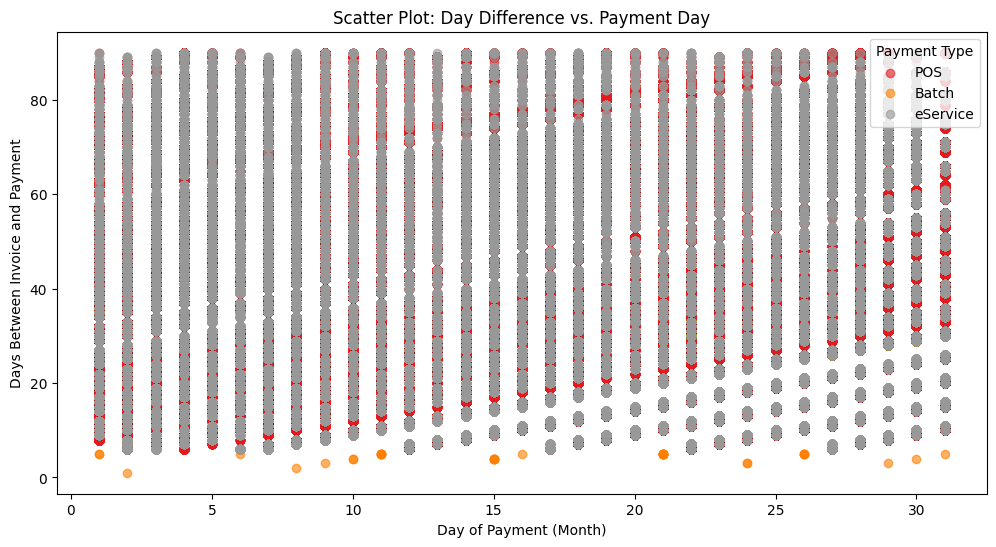

In [ ]:
# สุ่มตัวอย่างข้อมูล (เช่น สุ่มตัวอย่าง 10% ของข้อมูล)
sampled_target_group = target_group.sample(frac=0.3, random_state=1)

# สร้าง scatter plot โดยใช้ matplotlib
plt.figure(figsize=(12, 6))

# สร้างสีสำหรับแต่ละ payment_type
unique_payment_types = sampled_target_group['payment_type'].unique()
colors = plt.cm.Set1(np.linspace(0, 1, len(unique_payment_types)))
color_dict = dict(zip(unique_payment_types, colors))

for payment_type in unique_payment_types:
    subset = sampled_target_group[sampled_target_group['payment_type'] == payment_type]
    plt.scatter(subset['PAYMENT_DAY'], subset['DAYS_DIFF'], label=payment_type, color=color_dict[payment_type], alpha=0.6)

# ตั้งค่าชื่อกราฟและแกน
plt.xlabel('Day of Payment (Month)')
plt.ylabel('Days Between Invoice and Payment')
plt.title('Scatter Plot: Day Difference vs. Payment Day')
plt.legend(title='Payment Type', loc='upper right')

# แสดงกราฟ
plt.show()

### ดูวิธีการชำระ กับระยะเวลาชำระ

/var/folders/k6/lgrdm_ms2dq6f2946xjl4c800000gn/T/ipykernel_18553/1276980638.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_group['PAYMENT_DATE'] = pd.to_datetime(target_group['PAYMENT_DATE'], format='%Y-%m-%d')
/var/folders/k6/lgrdm_ms2dq6f2946xjl4c800000gn/T/ipykernel_18553/1276980638.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_group['PAYMENT_DAY'] = target_group['PAYMENT_DATE'].dt.day


['หักผ่านบัตรเครดิต' 'เงินสด' 'หักผ่านบัญชีธนาคาร'
 'รูดบัตรเครดิต หรือ Scanจ่าย' 'จ่ายผ่านเช็ค' 'จ่ายจากส่วนกลาง'
 'จ่ายผ่านแคชเชียร์เช็ค']
{'รูดบัตรเครดิต หรือ Scanจ่าย': array([0.89411765, 0.10196078, 0.10980392, 1.        ]), 'จ่ายจากส่วนกลาง': array([0.21568627, 0.49411765, 0.72156863, 1.        ]), 'เงินสด': array([0.59607843, 0.30588235, 0.63921569, 1.        ]), 'จ่ายผ่านเช็ค': array([1.        , 0.49803922, 0.        , 1.        ]), 'หักผ่านบัญชีธนาคาร': array([0.65098039, 0.3372549 , 0.15686275, 1.        ]), 'หักผ่านบัตรเครดิต': array([0.96862745, 0.50588235, 0.74901961, 1.        ]), 'จ่ายผ่านแคชเชียร์เช็ค': array([0.6, 0.6, 0.6, 1. ])}


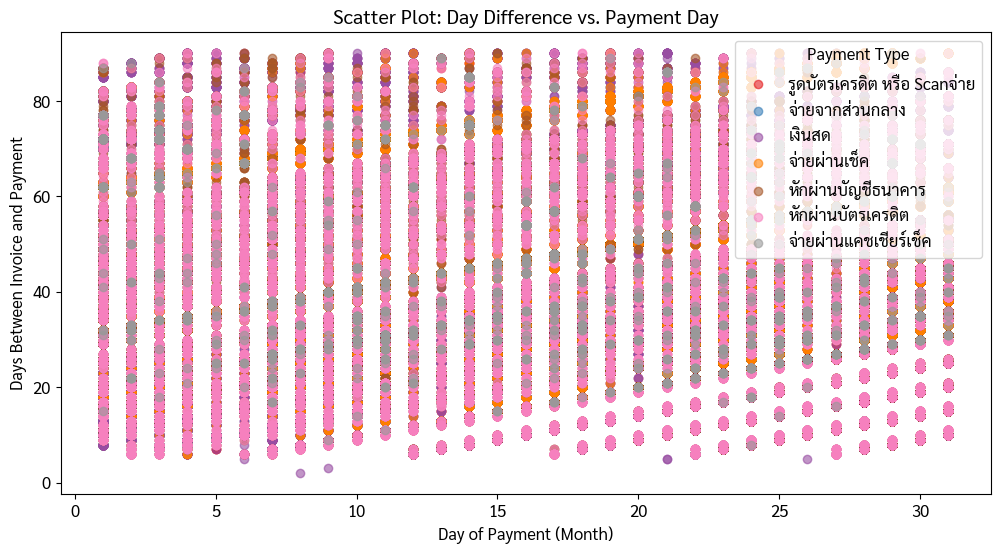

In [154]:
# กรองข้อมูลตามเงื่อนไข DAYS_DIFF อยู่ระหว่าง 0 ถึง 90
target_group = df[(df['DAYS_DIFF'] <= 90) & (df['DAYS_DIFF'] >= 0)]

# แปลงคอลัมน์ PAYMENT_DATE เป็น datetime
target_group['PAYMENT_DATE'] = pd.to_datetime(target_group['PAYMENT_DATE'], format='%Y-%m-%d')

# เพิ่มคอลัมน์ที่แสดงวันของการจ่ายเงินในเดือน
target_group['PAYMENT_DAY'] = target_group['PAYMENT_DATE'].dt.day

# แปลงค่าของ PAY_TYPE ตามพจนานุกรม
pay_type_dict = {
    "CA": "เงินสด",
    "DD": "หักผ่านบัญชีธนาคาร",
    "CQ": "จ่ายผ่านเช็ค",
    "DC": "หักผ่านบัตรเครดิต",
    "CC": "รูดบัตรเครดิต หรือ Scanจ่าย",
    "PY": "จ่ายจากส่วนกลาง",
    "CH": "จ่ายผ่านแคชเชียร์เช็ค"
}
target_group.loc[:, 'PAY_TYPE'] = target_group['PAY_TYPE'].map(pay_type_dict)

# ตรวจสอบค่าที่แปลงแล้วใน PAY_TYPE
print(target_group['PAY_TYPE'].unique())

# กรองข้อมูลที่มีค่า NaN ใน PAY_TYPE
target_group = target_group.dropna(subset=['PAY_TYPE'])

# สุ่มตัวอย่างข้อมูล (เช่น สุ่มตัวอย่าง 10% ของข้อมูล)
sampled_target_group = target_group.sample(frac=0.05, random_state=1)

# สร้าง scatter plot โดยใช้ matplotlib
plt.figure(figsize=(12, 6))

# สร้างสีสำหรับแต่ละ PAY_TYPE
unique_pay_types = sampled_target_group['PAY_TYPE'].unique()
colors = plt.cm.Set1(np.linspace(0, 1, len(unique_pay_types)))
color_dict = dict(zip(unique_pay_types, colors))

# แสดง color_dict เพื่อดูว่ามีค่าอะไรบ้าง
print(color_dict)

for pay_type in unique_pay_types:
    subset = sampled_target_group[sampled_target_group['PAY_TYPE'] == pay_type]
    plt.scatter(subset['PAYMENT_DAY'], subset['DAYS_DIFF'], label=pay_type, color=color_dict.get(pay_type, 'black'), alpha=0.6)

# ตั้งค่าชื่อกราฟและแกน
plt.xlabel('Day of Payment (Month)')
plt.ylabel('Days Between Invoice and Payment')
plt.title('Scatter Plot: Day Difference vs. Payment Day')
plt.legend(title='Payment Type', loc='upper right')

# แสดงกราฟ
plt.show()


# สร้างไฟล์ข้อมูลกลุ่มเป้าหมาย เพื่อนำไปใช้งาน

In [157]:
# กรองข้อมูลตามเงื่อนไข DAYS_DIFF percentile_75  percentile_25
target_group = df[(df['DAYS_DIFF'] <= percentile_75) & (df['DAYS_DIFF'] >= percentile_25)]

# แปลงคอลัมน์ PAYMENT_DATE เป็น datetime
target_group['PAYMENT_DATE'] = pd.to_datetime(target_group['PAYMENT_DATE'], format='%Y-%m-%d')
target_group['INVOICE_DATE'] = pd.to_datetime(target_group['INVOICE_DATE'], format='%Y-%m-%d')

# เพิ่มคอลัมน์ที่แสดงวันของการจ่ายเงินในเดือน
target_group.loc[:, 'PAYMENT_DAY'] = target_group['PAYMENT_DATE'].dt.day

# แปลงค่าของ PAY_TYPE ตามพจนานุกรม
pay_type_dict = {
    "CA": "เงินสด",
    "DD": "หักผ่านบัญชีธนาคาร",
    "CQ": "จ่ายผ่านเช็ค",
    "DC": "หักผ่านบัตรเครดิต",
    "CC": "รูดบัตรเครดิต หรือ Scanจ่าย",
    "PY": "จ่ายจากส่วนกลาง",
    "CH": "จ่ายผ่านแคชเชียร์เช็ค"
}
target_group.loc[:, 'PAY_TYPE'] = target_group['PAY_TYPE'].map(pay_type_dict)

target_group.to_csv("TARGET_GROUP_PAYMENT.csv", index=False, float_format="%.2f")